# Anomaly Detection (AD) basics.

## Anomaly detection algorithm 
More detail refer to Andrew Ng's course: https://www.coursera.org/lecture/machine-learning/algorithm-C8IJp

1. Choose feature `$x_{j}$` that you think might be indicate of anomalous examples, assume we get $n$ features/dimensions.
2. Fit parameter `$\mu_{1}, ..., \mu_{n}, \sigma_{1}^{2}, ..., \sigma_{n}^{2}$`. Where $(\mu_{j}, \sigma_{j}^{2}), j=1,...,n$, represent a normal distribution corresponding one of $n$ features. They can be estimated by following equation on a dataset with $m$ instances:   
>- `$\mu_{j} = \frac{1}{m}\sum_{i=1}^{m}x_{j}^{(i)}$`  
>- `$\sigma_{j}^{2} = \frac{1}{m}\sum_{i=1}^{m}(x_{j}^{(i)}-\mu_{j})^{2}$`, where `$\frac{1}{m}$` is used to replace `$\frac{1}{m-1}$` in traditional probability statistics because the number of instannces $m$ in machine learning always large enough.
3. Given new example $x$, compute $p(x)$:
>- `$p(x) = \prod_{j=1}^{n}p(x_{j}|\mu_{j},\sigma_{j}^{2})=\prod_{j=1}^{n} \frac{1}{\sqrt{2\pi}\sigma_{j}}exp(-\frac{(x_{j}-\mu_{j})^{2}}{2\sigma_{j}^{2}})$`  
>- Anomaly if `$p(x) < \epsilon$`
>- (The vectorization version definition is: `$p(x) = \frac{1}{\sqrt{(2\pi)^{k}det\Sigma}}exp(-\frac{1}{2}(x-\mu)^{T}\Sigma^{-1}(x-\mu))$`. More detail refer to : https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.multivariate_normal.html)

## Some valuable references

It should be note that there are no perfect reference and exists more or less errors.

- Andrew Ng's course on AD: https://www.coursera.org/lecture/machine-learning/algorithm-C8IJp
- Data copy from: https://github.com/deyachatterjee/ml-andrewng-python
    - There are also implementation of the programming assignments.
    - It should be note that the realization of multivariateGaussian is wrong.
    - Error in function visualizeFit: `np.array([10**i for i in np.arange(-20,0,3)])` should be changed to `mylevels = np.array([10**i for i in np.arange(-20,0,3, dtype=np.float)])`.
- A blog to detial the realization procedure:https://towardsdatascience.com/andrew-ngs-machine-learning-course-in-python-anomaly-detection-1233d23dba95
    - critical practice reference.
    - some errors in realized funtions.
    - some interesting visualization approaches.
- A good notebook: https://github.com/aqibsaeed/Anomaly-Detection
    - all critical functions (e.g. probability estimation) are realized by calling python embedding functions.
- Advanced reading
    - sklearn novelty and outlier detection: https://scikit-learn.org/stable/modules/outlier_detection.html#novelty-detection

## Organization

There are two dataset in the AD assigment in Andrew's couse, one has two dimensions/features and the other has 11 dimensions/features.

First of all I realize whole AD framework/algorithm based on dataset 1 (low-dimensional dataset is easy to visualization). Then apply the realized pipline on two dataset.

Finally I realized anomaly by using one-class SVM in sklearn.


In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.io import loadmat

%matplotlib inline

DIR_DATA = '/Users/huangfanling/workspace/bitbucket/mlpy/mlpy/ad/data'

## AD on two dimensional dataset

### Load data and visualize

In [133]:
# load data
mat1 = loadmat(os.path.join(DIR_DATA, 'ex8data1.mat'))
X = mat1['X']
Xval = mat1['Xval']
yval = mat1['yval']
print(X.shape)
print(Xval.shape)
print(yval.shape)
# visualization
plt.scatter(X[:,0], X[:,1], marker='x')
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")

(307, 2)
(307, 2)
(307, 1)


### Critical funtions in AD framework

In [134]:
# Define critical functions in AD pipeline.
def normalize(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    return (X - mu) / sigma

def estimate_gaussian(X):
    """estimate normal distribution: N(mu, sigma2)
    :param X: 
    :return: 
    """
    m = X.shape[0]
    # estimate mean
    mu = (1.0/m) * np.sum(X, axis=0)
    # estimate variance
    # For exactly estimating, 1/(m-1) is always used in traditional probability statistics.
    # In machine learning, the number of instances always big enough so that (1/m) is always used.
    sigma2 = (1.0/m) * np.sum((X-mu)**2, axis=0) 
    
    return mu, sigma2

def estimate_probability_multivariate_gaussian(X, mu, sigma2):
    """estimate the probability density function for multivariate normal distribution.
    this function can be replaced by scipy.stats.multivariate_normal: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.multivariate_normal.html
    
    :param X: 
    :param mu: 
    :param sigma2: 
    :return: 
    """
    k = len(mu)
    # de-mean
    X = X - mu
    sigma2 = np.diag(sigma2)
    p = 1.0/np.sqrt(((2*np.pi)**k)*np.linalg.det(sigma2))*\
        np.exp(-0.5*np.sum(X @ np.linalg.inv(sigma2) * X, axis=1))
    return p

def visualize_contour(X, mu, sigma2):
    """ display three-dimensional data in two dimensions using contours, where z is the estimated 
    probability for each instance.
    
    :param X: 
    :param mu: 
    :param sigma2: 
    :return: 
    """
    plt.scatter(X[:,0], X[:,1], marker='x')
    plt.xlabel("Latency (ms)")
    plt.ylabel("Throughput (mb/s)")
    x1, x2 = np.meshgrid(np.linspace(0, 35, num=70), np.linspace(0, 35, num=70))
    z = estimate_probability_multivariate_gaussian(
        np.hstack((x1.reshape((-1,1)), x2.reshape((-1,1)))), mu, sigma2
    ).reshape(x1.shape)
    print(x1.shape, x2.shape, z.shape)
    contour_levels = np.array([10**i for i in np.arange(-20,0,3, dtype=np.float)])
    print(contour_levels.shape)
    plt.contour(x1, x2, z, contour_levels)
    
def select_threshold(yval, pval):
    """ F1 score is used here instead of accuracy because the dataset in AD is highly unbalanced. 
    :param yval: 
    :param pval: 
    :return: 
    """
    best_epsilon = 0
    best_f1score = 0
    pval_max = np.max(pval)
    pval_min = np.min(pval)
    stepsize = (pval_max - pval_min) / 1000
    print("pval_max={}, pval_min = {}, stepsize={}".format(
        pval_max, pval_min, stepsize
    ))
    epsilon_range = np.arange(pval_min, pval_max, stepsize)
    for epsilon in epsilon_range:
        yhat = (pval < epsilon)[:,np.newaxis]
        tp = np.sum((yval == np.ones(yval.shape)) & (yhat == np.ones(yhat.shape)))
        fp = np.sum((yval == np.zeros(yval.shape)) & (yhat == np.ones(yhat.shape)))
        fn = np.sum((yval == np.ones(yval.shape)) & (yhat == np.zeros(yhat.shape)))
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1score = 2*precision*recall/(precision+recall)
        #print(epsilon, precision, recall, f1score)
        if f1score > best_f1score:
            best_f1score = f1score
            best_epsilon = epsilon
    return best_epsilon, best_f1score

### Apply AD on dataset

In [147]:
# estimate model and visualize
mu, sigma2 = estimate_gaussian(X)
p = estimate_probability_multivariate_gaussian(X, mu, sigma2)
print(mu, mu.shape)
print(sigma2, sigma2.shape)
visualize_contour(X, mu, sigma2)

[ 14.11222578  14.99771051] (2,)
[ 1.83263141  1.70974533] (2,)
(70, 70) (70, 70) (70, 70)
(7,)


In [146]:
# select best threshold based on validation set
pval = estimate_probability_multivariate_gaussian(Xval, mu, sigma2)
best_epsilon, best_f1score = select_threshold(yval, pval)
print(best_epsilon, best_f1score)

pval_max=0.08990852779269493, pval_min = 4.513250930309714e-36, stepsize=8.990852779269493e-05
8.99085277927e-05 0.875


/Program/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:78: RuntimeWarning: invalid value encountered in long_scalars


(70, 70) (70, 70) (70, 70)
(7,)


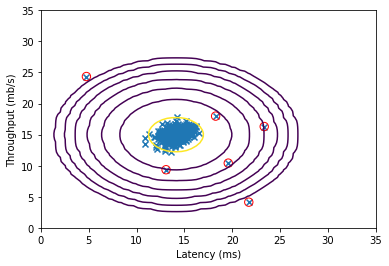

In [148]:
# visualize AD result on validation set
visualize_contour(X, mu, sigma2)
# Circling of anomalies
outliers = np.nonzero(p < best_epsilon*np.ones(p.shape))[0]
plt.scatter(X[outliers,0], X[outliers,1], marker="o", facecolor="none", edgecolors="r", s=70)

## AD on high dimensional dataset

In [143]:
# load data
mat2 = loadmat(os.path.join(DIR_DATA, 'ex8data2.mat'))
print('mat2', mat2.keys())
X2 = mat2['X']
Xval2 = mat2['Xval']
yval2 = mat2['yval']
print(X2.shape, Xval2.shape, yval2.shape)

# estimate model
mu2, sigma2_2 = estimate_gaussian(X2)
p2 = estimate_probability_multivariate_gaussian(X2, mu2, sigma2_2)
print(mu2.shape, sigma2_2.shape)
# training
pval2 = estimate_probability_multivariate_gaussian(Xval2, mu2, sigma2_2)
# find best threshold
best_epsilon2, best_f1score2 = select_threshold(yval2, pval2)
print("best epsilon = {}, best f1-score = {}".format(best_epsilon2, best_f1score2))
print("outlines: ", np.sum(p2 < best_epsilon2 * np.ones(p2.shape)))

mat2 dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])
(1000, 11) (100, 11) (100, 1)
(11,) (11,)
pval_max=1.3772288312874004e-15, pval_min = 5.953349076111392e-26, stepsize=1.3772288312278668e-18
best epsilon = 1.3772288907613575e-18, best f1-score = 0.6153846153846154
outlines:  117


/Program/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:78: RuntimeWarning: invalid value encountered in long_scalars


## AD Using One-Class SVM
Reference: https://github.com/aqibsaeed/Anomaly-Detection/blob/master/Anomaly%20Detection.ipynb

In [2]:
mat1 = loadmat(os.path.join(DIR_DATA, 'ex8data1.mat'))
X = mat1['X']
Xval = mat1['Xval']
yval = mat1['yval']

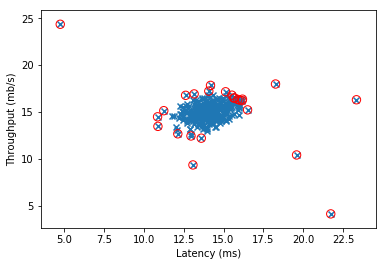

In [9]:
from sklearn import svm

clf = svm.OneClassSVM(nu=0.05, kernel="rbf", gamma=0.1)
clf.fit(Xval, yval)

yhat = clf.predict(X)
normal = X[yhat == 1]
abnormal = X[yhat == -1]

plt.scatter(X[:,0], X[:,1], marker='x')
plt.scatter(abnormal[:,0], abnormal[:,1], marker="o", facecolor="none", edgecolors="r", s=70)
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")